## Preparation

In [1]:
import numpy as np
from sympy import *
from sympy.solvers import solve
init_printing(use_unicode=True)

def num_sym(p: int) -> int:
    return int(p * (p + 1) / 2)

def solve_lyapunov_cov(M: Matrix, C: Matrix, p: int) -> Matrix:
    Sigma = MatrixSymbol("Sigma", p, p).as_explicit()
    Sigma_solved = solve(M*Sigma + Sigma*M.T + C, Sigma)
    scheme = [[Sigma_solved[Sigma[i,j]] for i in range(p)] for j in range(p)]
    Sigma_new = Matrix(scheme)
    return Sigma_new

def create_A_Sigma(cov: Matrix, p: int) -> Matrix:
    row_num = num_sym(p=p)
    col_num = int(p * p)
    A_Sigma = MatrixSymbol("A", row_num, col_num).as_mutable()
    for l in range(p):
        for k in range(l+1):
            for i in range(p):
                for j in range(p):
                    if (j != k) & (j != l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = 0
                    elif (j == k) & (k != l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = cov[l, i]
                    elif (j == l) & (l != k):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = cov[k, i]
                    elif (j == k) & (j == l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = 2 * cov[j, i]
    return A_Sigma

def create_A(A_Sigma: Matrix, mean: Matrix, p: int) -> Matrix:
    identity = mean[0] * eye(p)
    for i in range(1, p):
        identity = Matrix.hstack(identity, mean[i] * eye(p))
    return Matrix.vstack(A_Sigma, identity)

def create_c(vech_C: Matrix, b: float, index: int, p: int) -> Matrix:
    unit_vector = eye(p).col(index)
    return Matrix. vstack(vech_C, - b * unit_vector)

## Test 1
1000 true matrices $M^*$ $\to$ estimate $\hat{M}$ by deleting each one of the five equations once.

This gives 5000 estimates, save them and also their Frobenius distance to the true $M^*$ and the determinante of the corresponding $A$.

In [2]:
p = 2
num_eq = num_sym(p=p) + p
num_seed = 1000
d = 0.9 # Probability of edges in graph

m11, m12 = symbols('m11'), symbols('m12')
m21, m22 = symbols('m21'), symbols('m22')
M = Matrix([[m11, m12], [m21, m22]])

C = 2 * eye(p) # volatility matrix

vec_M = Matrix([[M[j, i]] for i in range(p) for j in range(p)]) # j faster than i
vech_C = Matrix([[C[i, j]] for i in range(p) for j in range(i, p)])

# Intervention
index_intervention = 1
b = 1
unit_v = eye(p).col(index_intervention)

estimates_2nodes_test1 = np.empty(shape=(num_seed, num_eq), dtype=object)
statistics_2nodes_test1 = np.empty(shape=(num_seed*num_eq, 2), dtype=float)

for index in range(num_eq):
    for seed in range(1, num_seed + 1):
        index_deletion = index
        np.random.seed(seed=seed)

        bernoulli_matrix = np.random.binomial(1, d, (p, p))
        normal_matrix = np.random.normal(0, 1, (p, p))

        temp_M = bernoulli_matrix * normal_matrix
        for i in range(p): # adjust diagonal entries s.t. M stable
            row_sum = np.sum(np.abs(temp_M[i, :])) - np.abs(temp_M[i, i])
            temp_M[i, i] = - row_sum - np.abs(normal_matrix[i,i])

        concrete_M = Matrix(temp_M)

        cov = solve_lyapunov_cov(M=concrete_M, C=C, p=p)
        mean = b * concrete_M.inv() * unit_v

        A_Sigma = create_A_Sigma(cov=cov, p=p)
        A = create_A(A_Sigma=A_Sigma, mean=mean, p=p)

        c = create_c(vech_C=vech_C, b=b, index=index_intervention, p=p)

        A.row_del(index_deletion)
        c.row_del(index_deletion)
        temp = A * vec_M + c

        det_A = det(A)

        if det_A != 0:
            # M_est = M.subs(solve(A * vec_M + c, vec_M))
            M_est = M.subs(solve(temp, vec_M))
            M_est_np = matrix2numpy(M_est).astype(float)
            M_true = matrix2numpy(concrete_M).astype(float)
            frob = np.linalg.norm(M_est_np - M_true)

            estimates_2nodes_test1[seed - 1, index] = M_est_np.round(3)
            statistics_2nodes_test1[num_seed * index + (seed - 1), 0] = det_A
            statistics_2nodes_test1[num_seed * index + (seed - 1), 1] = frob
        else:
            statistics_2nodes_test1[num_seed * index + (seed - 1), 0] = det_A
            statistics_2nodes_test1[num_seed * index + (seed - 1), 1] = 0.0

In [5]:
p = 2
num_eq = num_sym(p=p) + p
num_seed = 100
d = 0.9 # Probability of edges in graph

m11, m12 = symbols('m11'), symbols('m12')
m21, m22 = symbols('m21'), symbols('m22')
M = Matrix([[m11, m12], [m21, m22]])

C = 2 * eye(p) # volatility matrix

vec_M = Matrix([[M[j, i]] for i in range(p) for j in range(p)]) # j faster than i
vech_C = Matrix([[C[i, j]] for i in range(p) for j in range(i, p)])

# Intervention
index_intervention = 1
b = 1
unit_v = eye(p).col(index_intervention)

estimates_2nodes_test1 = np.empty(shape=(num_seed, num_eq), dtype=object)
statistics_2nodes_test1 = np.empty(shape=(num_seed*num_eq, 3), dtype=float)

for index in range(num_eq):
    for seed in range(1, num_seed + 1):
        index_deletion = index
        np.random.seed(seed=seed)

        # bernoulli_matrix = np.random.binomial(1, d, (p, p))
        normal_matrix = np.random.normal(0, 1, (p, p))

        # temp_M = bernoulli_matrix * normal_matrix
        for i in range(p): # adjust diagonal entries s.t. M stable
            row_sum = np.sum(np.abs(normal_matrix[i, :])) - np.abs(normal_matrix[i, i])
            normal_matrix[i, i] = - row_sum - np.abs(normal_matrix[i,i])

        concrete_M = Matrix(normal_matrix)

        cov = solve_lyapunov_cov(M=concrete_M, C=C, p=p)
        mean = b * concrete_M.inv() * unit_v

        A_Sigma = create_A_Sigma(cov=cov, p=p)
        A = create_A(A_Sigma=A_Sigma, mean=mean, p=p)
        A_np = matrix2numpy(A).astype(float)
        rang = np.linalg.matrix_rank(A_np)

        c = create_c(vech_C=vech_C, b=b, index=index_intervention, p=p)

        A.row_del(index_deletion)
        c.row_del(index_deletion)
        temp = A * vec_M + c

        det_A = det(A)

        if det_A != 0:
            # M_est = M.subs(solve(A * vec_M + c, vec_M))
            M_est = M.subs(solve(temp, vec_M))
            M_est_np = matrix2numpy(M_est).astype(float)
            M_true = matrix2numpy(concrete_M).astype(float)
            frob = np.linalg.norm(M_est_np - M_true)

            estimates_2nodes_test1[seed - 1, index] = M_est_np.round(3)
            statistics_2nodes_test1[num_seed * index + (seed - 1), 0] = det_A
            statistics_2nodes_test1[num_seed * index + (seed - 1), 1] = frob
            statistics_2nodes_test1[num_seed * index + (seed - 1), 2] = rang
        else:
            statistics_2nodes_test1[num_seed * index + (seed - 1), 0] = det_A
            statistics_2nodes_test1[num_seed * index + (seed - 1), 1] = 0.0
            statistics_2nodes_test1[num_seed * index + (seed - 1), 2] = rang

In [6]:
statistics_2nodes_test1

array([[8.94449455e-05, 2.61690831e-12, 4.00000000e+00],
       [1.72590601e-01, 7.67207301e-15, 4.00000000e+00],
       [7.07635954e-04, 1.23184759e-12, 4.00000000e+00],
       ...,
       [1.06325483e+00, 2.13174385e-14, 4.00000000e+00],
       [5.53368813e-01, 2.39916730e-14, 4.00000000e+00],
       [6.50328492e-01, 1.26205796e-14, 4.00000000e+00]])

How many times was the estimate not unique? In total 27 times not unique with $\text{det}(A)=0$.

In [7]:
(num_eq * num_seed) - np.count_nonzero(statistics_2nodes_test1[:, 0])

By looking at the data, we see that this happened in rows indexed by 86, 212, 540, 545, 566, 575, 660, 891 and 892 and always for deleting rows 1, 2 and 4 from the equations, not for rows 3 and 5.

In [4]:
unique_estimates_2nodes_test1 = np.delete(estimates_2nodes_test1, [86, 212, 540, 545, 566, 575, 660, 891, 892], axis=0)

Are the estimates for the same true matrix $M^*$ always the same? Yes, they are!

In [5]:
for seed in range(len(unique_estimates_2nodes_test1)):
    diff_0_1 = np.linalg.norm(unique_estimates_2nodes_test1[seed, 0] - unique_estimates_2nodes_test1[seed, 1])
    diff_0_2 = np.linalg.norm(unique_estimates_2nodes_test1[seed, 0] - unique_estimates_2nodes_test1[seed, 2])
    diff_0_3 = np.linalg.norm(unique_estimates_2nodes_test1[seed, 0] - unique_estimates_2nodes_test1[seed, 3])
    diff_0_4 = np.linalg.norm(unique_estimates_2nodes_test1[seed, 0] - unique_estimates_2nodes_test1[seed, 4])
    diff_1_2 = np.linalg.norm(unique_estimates_2nodes_test1[seed, 1] - unique_estimates_2nodes_test1[seed, 2])
    diff_1_3 = np.linalg.norm(unique_estimates_2nodes_test1[seed, 1] - unique_estimates_2nodes_test1[seed, 3])
    diff_1_4 = np.linalg.norm(unique_estimates_2nodes_test1[seed, 1] - unique_estimates_2nodes_test1[seed, 4])
    diff_2_3 = np.linalg.norm(unique_estimates_2nodes_test1[seed, 2] - unique_estimates_2nodes_test1[seed, 3])
    diff_2_4 = np.linalg.norm(unique_estimates_2nodes_test1[seed, 2] - unique_estimates_2nodes_test1[seed, 4])
    diff_3_4 = np.linalg.norm(unique_estimates_2nodes_test1[seed, 3] - unique_estimates_2nodes_test1[seed, 4])
    if diff_0_1 != 0:
        print("Matrizen 1 und 2 sind ungleich bei ", seed)
        continue
    elif diff_0_2 != 0:
        print("Matrizen 1 und 3 sind ungleich bei ", seed)
        continue
    elif diff_0_2 != 0:
        print("Matrizen 1 und 3 sind ungleich bei ", seed)
        continue
    elif diff_0_3 != 0:
        print("Matrizen 1 und 4 sind ungleich bei ", seed)
        continue
    elif diff_0_4 != 0:
        print("Matrizen 1 und 5 sind ungleich bei ", seed)
        continue
    elif diff_1_2 != 0:
        print("Matrizen 2 und 3 sind ungleich bei ", seed)
        continue
    elif diff_1_3 != 0:
        print("Matrizen 2 und 4 sind ungleich bei ", seed)
        continue
    elif diff_1_4 != 0:
        print("Matrizen 2 und 5 sind ungleich bei ", seed)
        continue
    elif diff_2_3 != 0:
        print("Matrizen 3 und 4 sind ungleich bei ", seed)
        continue
    elif diff_2_4 != 0:
        print("Matrizen 3 und 5 sind ungleich bei ", seed)
        continue
    elif diff_3_4 != 0:
        print("Matrizen 4 und 5 sind ungleich bei ", seed)
        continue

## Test 2
How do the matrices $M^*$ that did not produce unique solutions look like? They all have 0 next to the diagonale.

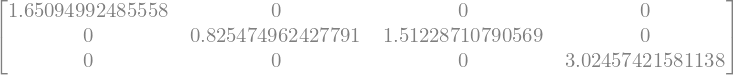

In [6]:
np.random.seed(seed=541)

bernoulli_matrix = np.random.binomial(1, d, (p, p))
normal_matrix = np.random.normal(0, 1, (p, p))

temp_M = bernoulli_matrix * normal_matrix
for i in range(p): # adjust diagonal entries s.t. M stable
    row_sum = np.sum(np.abs(temp_M[i, :])) - np.abs(temp_M[i, i])
    temp_M[i, i] = - row_sum - np.abs(normal_matrix[i,i])

concrete_M = Matrix(temp_M)

cov = solve_lyapunov_cov(M=concrete_M, C=C, p=p)
mean = b * concrete_M.inv() * unit_v

A_Sigma = create_A_Sigma(cov=cov, p=p)
A = create_A(A_Sigma=A_Sigma, mean=mean, p=p)

A_Sigma

## Test 3
How is the goodness of fit for this estimation technique? Generate 10000 instances of a true matrix $M^*$, choose randomly which equation to eliminate, estimate $\hat{M}$ and calculate the frobenius distance to the true $M^*$.

In [7]:
frob_2nodes_test3 = np.empty(shape=(10000), dtype=float)

for seed in range(1, 10001):
    index_deletion = 2 + 2 * np.random.binomial(n=1, p=0.5) # always delete 3 or 5 -> get solution.
    np.random.seed(seed=seed)

    bernoulli_matrix = np.random.binomial(1, d, (p, p))
    normal_matrix = np.random.normal(0, 1, (p, p))

    temp_M = bernoulli_matrix * normal_matrix
    for i in range(p): # adjust diagonal entries s.t. M stable
        row_sum = np.sum(np.abs(temp_M[i, :])) - np.abs(temp_M[i, i])
        temp_M[i, i] = - row_sum - np.abs(normal_matrix[i,i])

    concrete_M = Matrix(temp_M)

    cov = solve_lyapunov_cov(M=concrete_M, C=C, p=p)
    mean = b * concrete_M.inv() * unit_v

    A_Sigma = create_A_Sigma(cov=cov, p=p)
    A = create_A(A_Sigma=A_Sigma, mean=mean, p=p)

    c = create_c(vech_C=vech_C, b=b, index=index_intervention, p=p)

    A.row_del(index_deletion)
    c.row_del(index_deletion)
    temp = A * vec_M + c

    M_est = M.subs(solve(temp, vec_M))
    M_est_np = matrix2numpy(M_est).astype(float)
    M_true = matrix2numpy(concrete_M).astype(float)
    frob_2nodes_test3[seed-1] = np.linalg.norm(M_est_np - M_true)


In [29]:
np.max(frob_2nodes_test3)

## Test 4
The same as test 1 but this time check if $\texttt{solve}$ gives a solution, not for $\text{det}(A) = 0$.

In [28]:
estimates_2nodes_test4 = np.empty(shape=(num_seed, num_eq), dtype=object)
statistics_2nodes_test4 = np.empty(shape=(num_seed*num_eq, 3), dtype=float)

for index in range(num_eq):
    for seed in range(1, num_seed + 1):
        index_deletion = index
        np.random.seed(seed=seed)

        bernoulli_matrix = np.random.binomial(1, d, (p, p))
        normal_matrix = np.random.normal(0, 1, (p, p))

        temp_M = bernoulli_matrix * normal_matrix
        for i in range(p): # adjust diagonal entries s.t. M stable
            row_sum = np.sum(np.abs(temp_M[i, :])) - np.abs(temp_M[i, i])
            temp_M[i, i] = - row_sum - np.abs(normal_matrix[i,i])

        concrete_M = Matrix(temp_M)

        cov = solve_lyapunov_cov(M=concrete_M, C=C, p=p)
        mean = b * concrete_M.inv() * unit_v

        A_Sigma = create_A_Sigma(cov=cov, p=p)
        A = create_A(A_Sigma=A_Sigma, mean=mean, p=p)

        c = create_c(vech_C=vech_C, b=b, index=index_intervention, p=p)

        A.row_del(index_deletion)
        c.row_del(index_deletion)
        temp = A * vec_M + c

        det_A = det(A)
        solution = solve(temp, vec_M)

        if len(solution) == 4:
            M_est = M.subs(solution)
            M_est_np = matrix2numpy(M_est).astype(float)
            M_true = matrix2numpy(concrete_M).astype(float)
            frob = np.linalg.norm(M_est_np - M_true)

            estimates_2nodes_test4[seed - 1, index] = M_est_np.round(3)
            statistics_2nodes_test4[num_seed * index + (seed - 1), 0] = det_A
            statistics_2nodes_test4[num_seed * index + (seed - 1), 1] = frob
            statistics_2nodes_test4[num_seed * index + (seed - 1), 2] = 1
        else:
            statistics_2nodes_test4[num_seed * index + (seed - 1), 0] = det_A
            statistics_2nodes_test4[num_seed * index + (seed - 1), 1] = 0.0
            statistics_2nodes_test4[num_seed * index + (seed - 1), 2] = 0

In [ ]:
estimates_2nodes_test4

Problem encountered: for $\texttt{seed}=541$ and deleting first row, we get a solution for entries $m_{12}$, $m_{21}$ and $m_{22}$ but not $m_{11}$. This means, the vector $\texttt{solution}$ is not empt but also not "full" $\to$ update this in if-condition.

***Result:*** Missing values for seed = $\{87, 213, 541, 546, 567, 576, 661, 892, 893\}$, so the same ones as seen in test 1. Here, having $\text{det}(A)=0$ and having a solution is equivalent.